# Simulating gamma-ray transport in the atmosphere with the cosi-atmosphere package 

Import the COSI atmosphere package

In [1]:
from cosi_atmosphere.response.AtmosphericProfile import Atmosphere
from cosi_atmosphere.response.MassModels import MakeMassModels
from cosi_atmosphere.response.RunSims import Simulate
from cosi_atmosphere.response.ProcessSims import Process
import numpy as np
import os

## Make the Mass Model
The first step is to make an atmospheric model using the Atmosphere class. This provides an altitude density profile for the different species of the atmosphere. For the atmospheric model you need to specify the date, latitude and longitude, as well as the atmospheric spacing. Here we will use a spacing of 100 m.  

In [2]:
instance = Atmosphere()
date = np.array(['2016-06-13 12:00:00'], dtype="datetime64[h]")
lat = -5.66
lon = -107.38
alts = np.linspace(0, 200, 2001) # km; spacing is 0.1 km (100 m) 
atm_model = instance.get_atm_profile("rep_atm_model.dat",date,lon,lat,alts)

Let's take a look at the first 5 lines of the output file to see what it contains:

In [3]:
%%capture
os.system("head -n 5 rep_atm_model.dat")

altitude[km]	mass_density[kg/m3]	N2[m-3]	O2[m-3]	O[m-3]	He[m-3]	H[m-3]	Ar[m-3]	N[m-3]	anomalous_oxygen[m-3]	NO[m-3]	Temperature[k]
0.000000e+00	1.176653e+00	1.911429e+25	5.125639e+24	0.000000e+00	1.272904e+20	0.000000e+00	2.284374e+23	0.000000e+00	0.000000e+00	0.000000e+00	2.966827e+02
1.000000e-01	1.164742e+00	1.892081e+25	5.073756e+24	0.000000e+00	1.260020e+20	0.000000e+00	2.261251e+23	0.000000e+00	0.000000e+00	0.000000e+00	2.962918e+02
2.000000e-01	1.152961e+00	1.872944e+25	5.022437e+24	0.000000e+00	1.247275e+20	0.000000e+00	2.238379e+23	0.000000e+00	0.000000e+00	0.000000e+00	2.958947e+02
3.000000e-01	1.141304e+00	1.854006e+25	4.971656e+24	0.000000e+00	1.234664e+20	0.000000e+00	2.215747e+23	0.000000e+00	0.000000e+00	0.000000e+00	2.954918e+02


Next we need to make a mass model of the atmosphere. This is done with the MakeMassModels class, which takes as input the atmospheric model calculated in the previous step. Let's first define an instance of the class and plot the atmospheric profile:

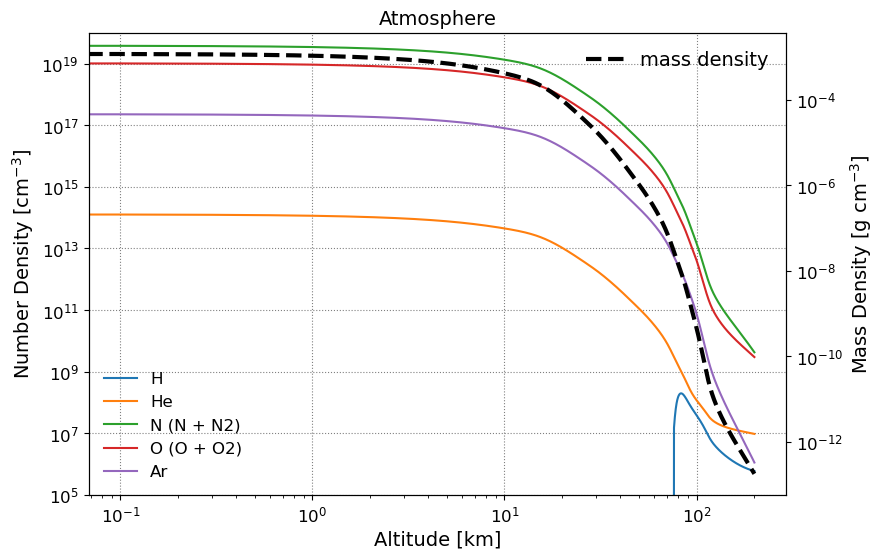

In [4]:
instance = MakeMassModels("rep_atm_model.dat")
instance.plot_atmosphere()

The left axis in the above plot shows the number density of the different atmospheric elements. The right axis shows the total mass density of all elements. 

Now let's define our mass model. Two options are available for this: rectangular and spherical. The simulations use a watched volume to detect all passing photons, and so we need to pass the altitude to use. Here we will use a rectangular geometry with a watched volume at 33 km.

In [5]:
instance.rectangular_model(33)

Using half-height [cm]: 5000.0
Watch index: 330


The output is written to atmosphere.geo. Let's take a look at the first 40 lines:

In [6]:
%%capture
os.system("head -n 40 atmosphere.geo")

# Atmosphere model

Name AtmoshpereModel

# Surrounding sphere:
SurroundingSphere 0.1 0 0 20000000.0 0.1

Volume World
World.Material Vacuum
World.Shape BOX 10240000000.000000 10240000000.000000 10240000000.000000
World.Visibility 1
World.Position 0 0 0
World.Mother 0

Include $(MEGALIB)/resource/examples/geomega/materials/Materials.geo

Material MaterialSlice_0_1
MaterialSlice_0_1.Density 0.001176653
MaterialSlice_0_1.ComponentByAtoms He 2
MaterialSlice_0_1.ComponentByAtoms N 784845
MaterialSlice_0_1.ComponentByAtoms O 210462
MaterialSlice_0_1.ComponentByAtoms Ar 4689

Volume VolumeSlice_0_1
VolumeSlice_0_1.Material MaterialSlice_0_1
VolumeSlice_0_1.Shape BOX 51200000.000000 51200000.000000 5000.0
VolumeSlice_0_1.Visibility  1
VolumeSlice_0_1.Position 0 0 5000.0
VolumeSlice_0_1.Mother World

Material MaterialSlice_1_2
MaterialSlice_1_2.Density 0.0011647419999999999
MaterialSlice_1_2.ComponentByAtoms He 2
MaterialSlice_1_2.ComponentByAtoms N 784845
MaterialSlice_1_2.ComponentByAtoms O 

You can see that each volume slice is a large rectangular slab with a half-width of 5000 cm. The material of each volume slice corresponds to the atmospheric profile. 

Now let's take a look at the last 20 lines of the geometry file:

In [7]:
%%capture
os.system("tail -n 20 atmosphere.geo")

MaterialSlice_1999_2000.Density 1.783777e-13
MaterialSlice_1999_2000.ComponentByAtoms H 81
MaterialSlice_1999_2000.ComponentByAtoms He 1311
MaterialSlice_1999_2000.ComponentByAtoms N 587675
MaterialSlice_1999_2000.ComponentByAtoms O 410776
MaterialSlice_1999_2000.ComponentByAtoms Ar 155

Volume VolumeSlice_1999_2000
VolumeSlice_1999_2000.Material MaterialSlice_1999_2000
VolumeSlice_1999_2000.Shape BOX 51200000.000000 51200000.000000 5000.0
VolumeSlice_1999_2000.Visibility  1
VolumeSlice_1999_2000.Position 0 0 19995000.0
VolumeSlice_1999_2000.Mother World

Volume TestVolume
TestVolume.Material MaterialSlice_330_331
TestVolume.Shape BOX 51200000.000000 51200000.000000 5000.0
TestVolume.Visibility 1
TestVolume.Position 0 0 0
TestVolume.Mother VolumeSlice_330_331


The last block here is our watched volume (called TestVolume). Here we are watching VolumeSlice_330_331, which corresponds to the rectangular slab at an altitude of 33 km. In principle, we can let the watched volume be whatever we want. For example, to use a sphere with a radius of 100 cm within the same volume slice, you would replace the shape with: TestVolume.Shape Sphere 0 100. This option is not yet hard coded, so if a different watched volume is needed, you will have to do it by hand for now.</br>

## Make the Source File
The other thing we need for the simulations is the source file. For the rectangular geometry we use a narrow beam, and an example file is provided: AtmospherePencilBeam.source. Let's take a look:

In [8]:
%%capture
os.system("cat AtmospherePencilBeam.source")

# An atmosphere simulation

Version         1
Geometry        atmosphere.geo

# Physics list
PhysicsListEM                        LivermorePol
PhysicsListEMActivateFluorescence    false

# Output formats
StoreCalibrated                      true
StoreSimulationInfo                  init-only
StoreSimulationInfoIonization        false
StoreSimulationInfoWatchedVolumes    TestVolume
StoreOnlyTriggeredEvents             false
DiscretizeHits                       true

DefaultRangeCut 100

Run SpaceSim
SpaceSim.FileName         Atmosphere_PencilBeam
SpaceSim.Triggers         100000

SpaceSim.Source Beam
Beam.ParticleType           1
Beam.Beam                   HomogeneousBeam 0 0 20000000   0 0 -1  1
Beam.Spectrum               Linear 10 10000
Beam.Flux                   1.0



For demonstration purposes we are only simulating 100,000 triggers. In practice, ~ 1 million - 5 million should provide sufficient statistics. Note: Even 100,000 triggers takes a long time. For an even faster test, try simulating just 1000 triggers. We have a homogeneous narrow beam (r = 1cm) placed on axis at the top of the atmosphere (200 km), which throws photons straight down. The spectrum is linear between 10 - 10000 keV. </br>

The inputs for HomogeneousBeam are: x y z nx ny nz r. We can place the beam off-axis by changing x, nx, and nz. For example, suppose we want to do 50 degrees off axis with a watched altitude of 33 km. We can determine what values we need to use by running the following:

In [9]:
angle = 50.0 # degrees
altitude = 33.0 # km
instance.get_cart_vectors(angle, altitude)


x [cm]: 19902284.996323306
nx [cm]: -0.766044443118978
nz [cm]: -0.6427876096865394



Replacing the corresponding inputs in the source file with these values will produce an off-axis source. </br>

## Run the Simulations 
Once we have the mass model and the source file, we can run the simulations. Let's define an instance of the Simulation class and make a short run. 
Note: This can take several hours to complete. If you want to run a faster simulation, reduce the number of triggers in the source file. 

In [10]:
instance = Simulate()
instance.run_sim("AtmospherePencilBeam.source", seed=3000, verbosity=0)


**************************************************************************
*                                                                        *
*                Cosima - the cosmic simulator of MEGAlib                *
*                                                                        *
*             This program is part of MEGAlib version 3.99.02            *
*                (C) by Andreas Zoglauer and contributors                *
*                                                                        *
*                      Master reference for MEGAlib:                     *
*            A. Zoglauer et al., NewAR 50 (7-8), 629-632, 2006           *
*                                                                        *
*            For more information about MEGAlib please visit:            *
*                        http://megalibtoolkit.com                       *
*                                                                        *
************************

The above command is a python wrapper for cosima, and it will produce the .sim file. Now let's parse the sim file. This will produce two .dat files: one with information for all thrown photons and another with information for all detected photons.

In [11]:
instance.parse_sim_file("Atmosphere_PencilBeam.inc1.id1.sim")

Let's take a look at the output format:

In [13]:
%%capture
os.system("head -n 5 all_thrown_events.dat")

id	ei[keV]	xi[cm]	yi[cm]	zi[cm]	xdi[cm]	ydi[cm]	zdi[cm]
1	6.041339000e+03	7.339900000e-01	1.017700000e-01	2.000000000e+07	0.000000000e+00	0.000000000e+00	-1.000000000e+00
2	7.831685000e+03	6.970800000e-01	-4.249200000e-01	2.000000000e+07	0.000000000e+00	0.000000000e+00	-1.000000000e+00
3	3.470339000e+03	-1.828400000e-01	-2.275600000e-01	2.000000000e+07	0.000000000e+00	0.000000000e+00	-1.000000000e+00
4	6.729603000e+03	3.257600000e-01	7.572800000e-01	2.000000000e+07	0.000000000e+00	0.000000000e+00	-1.000000000e+00


In [14]:
%%capture
os.system("head -n 5 event_list.dat")

id	em[keV]	xm[cm]	ym[cm]	zm[cm]	xdm[cm]	ydm[cm]	zdm[cm]
1	6.041339000e+03	7.339900000e-01	1.017700000e-01	3.310000000e+06	0.000000000e+00	0.000000000e+00	-1.000000000e+00
2	7.831685000e+03	6.970800000e-01	-4.249200000e-01	3.310000000e+06	0.000000000e+00	0.000000000e+00	-1.000000000e+00
3	3.470339000e+03	-1.828400000e-01	-2.275600000e-01	3.310000000e+06	0.000000000e+00	0.000000000e+00	-1.000000000e+00
4	6.729603000e+03	3.257600000e-01	7.572800000e-01	3.310000000e+06	0.000000000e+00	0.000000000e+00	-1.000000000e+00


Note that the first file has all the initial information, and the second file has all the measured information. </br>

## Process the Simulations 
Now we can process the simulations using the Process class. When defining an instance of the Process class we need to specify off-axis angle of the source. As a simple example, let's bin the data and make some diagnostic plots:

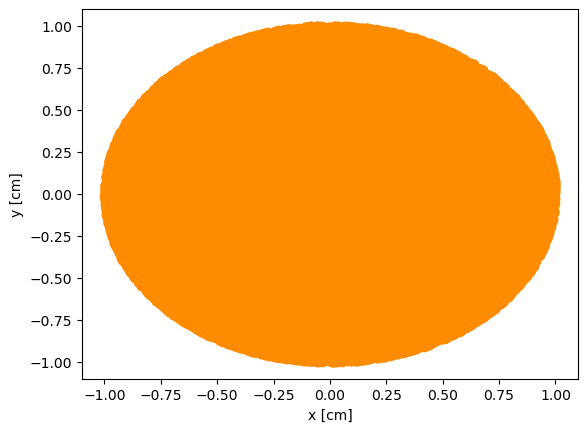

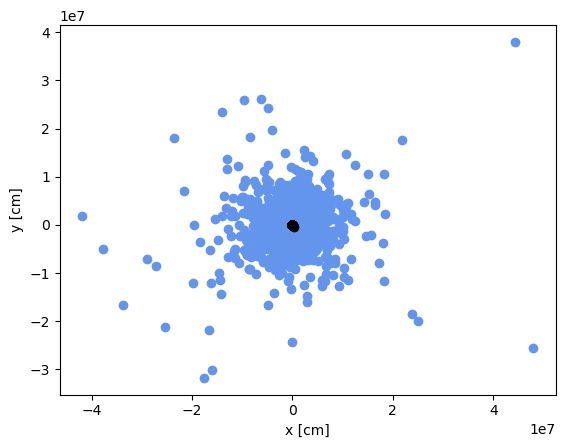

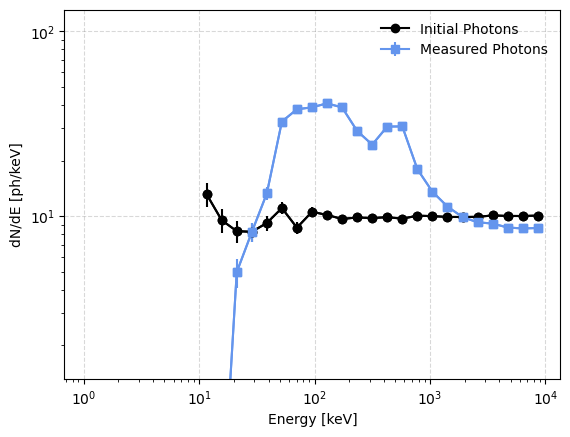


Number of starting photons: 100000.0
Number of measured photons: 107038.62565373076



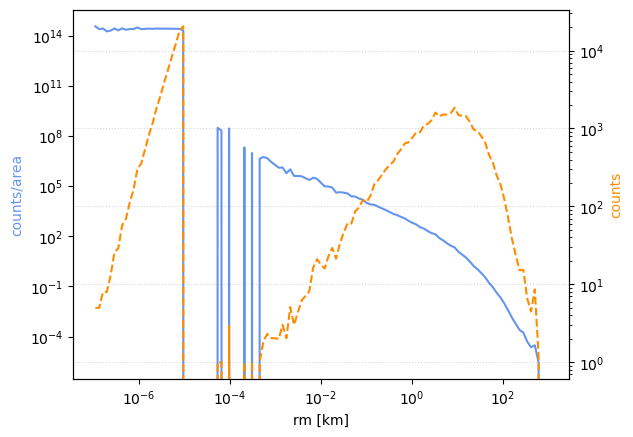

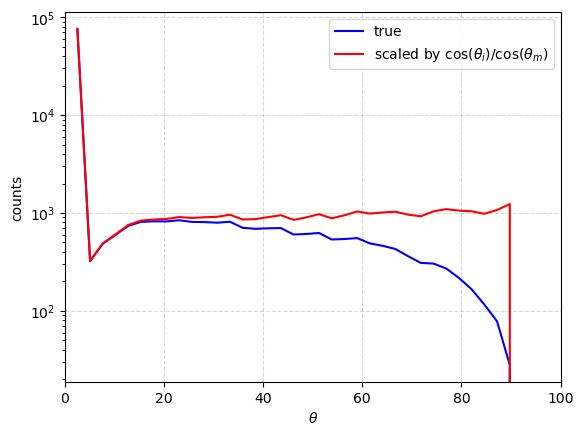

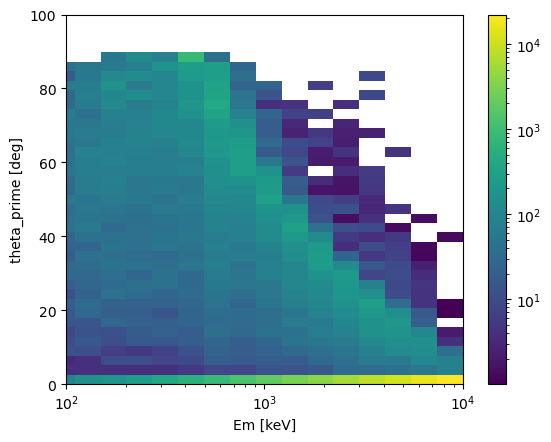

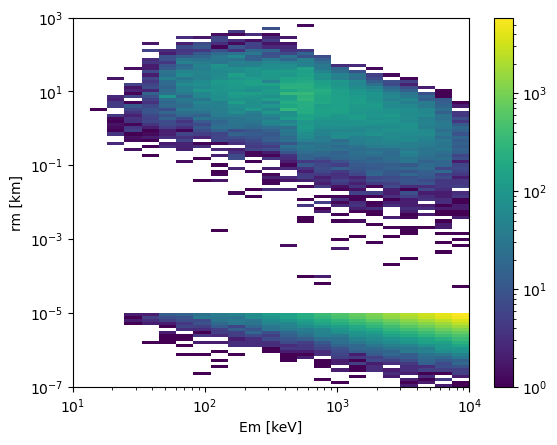

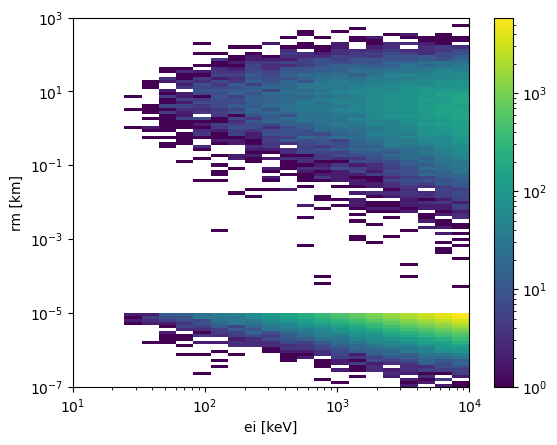

In [3]:
instance = Process(0)
instance.bin_sim()
instance.make_scattering_plots()

The statistics are not great since we only ran 100,000 triggers, but this gives an idea of the output. </br>
summary of output plots: </br>
plot 1: x y positions of starting photons  </br>
plot 2: x y positions of measured photons: blue = scatterd, black = un-scattered </br>
plot 3: spectrum of initial and measured photons </br>
plot 4: distribution of counts versus the radius from the center of the beam (rm) </br>
plot 5: distribution of counts versus the photon's incident angle (theta_prime) </br>
plot 6: projection of counts onto incident angle and measured energy (Em) axes </br>
plot 7: projection of counts onto rm and Em axes</br>
plot 8: projection of counts onto rm and initial energy (Ei) axes

## Get Atmospheric Response 
Now let's get the atmospheric response. The first three outputs will show the energy dispersion matrices for the transmitted component, the scattered component, and the total (which is the sum of the transmitted and scattered components). The last output will show the transmissoin probability for all three components, which is the projection of the energy dispersion matrices onto the initial energy axis. See Karwin+23 for more details. 

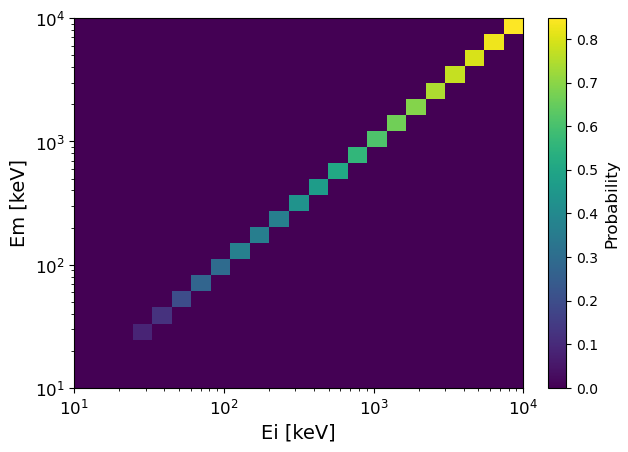

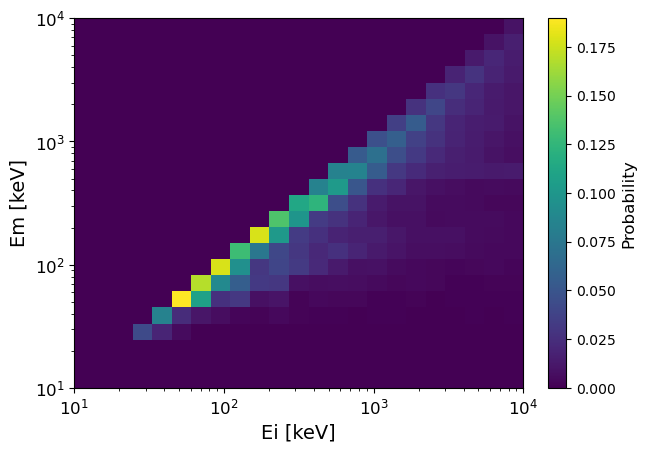

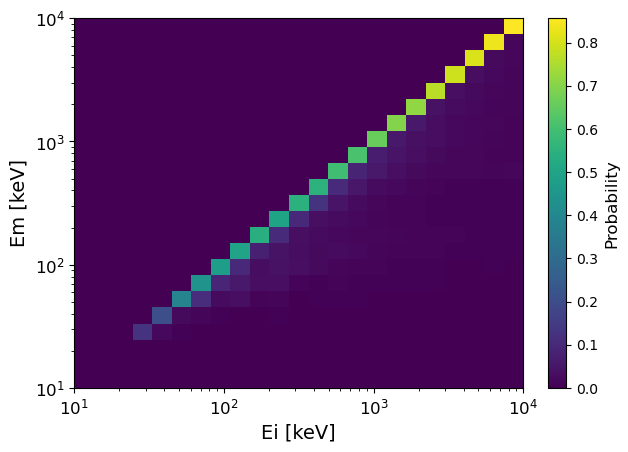

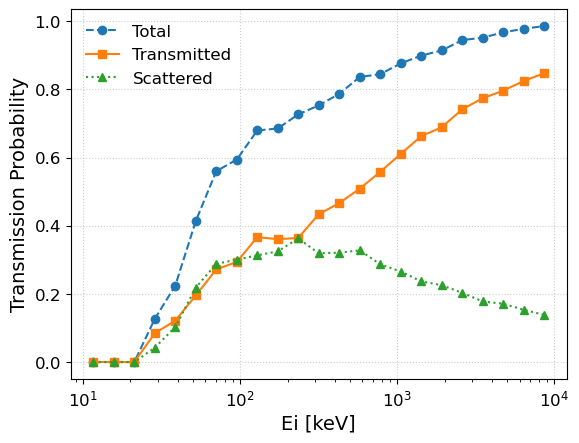

In [4]:
instance.get_total_edisp_matrix()

Finally, let's get the correction factor and correction factor ratio (also defined in Karwin+23). We'll use a power law spectral model with index 2.

/zfs/astrohe/ckarwin/My_Class_Library/COSI/cosi-atmosphere/cosi_atmosphere/response/ProcessSims.py:823: RuntimeWarning: divide by zero encountered in divide
  c_ratio = c_total/c_beam
/zfs/astrohe/ckarwin/My_Class_Library/COSI/cosi-atmosphere/cosi_atmosphere/response/ProcessSims.py:823: RuntimeWarning: invalid value encountered in divide
  c_ratio = c_total/c_beam
/zfs/astrohe/ckarwin/My_Class_Library/COSI/cosi-atmosphere/cosi_atmosphere/response/ProcessSims.py:831: RuntimeWarning: invalid value encountered in divide
  s_frac = p_scattered / p_total


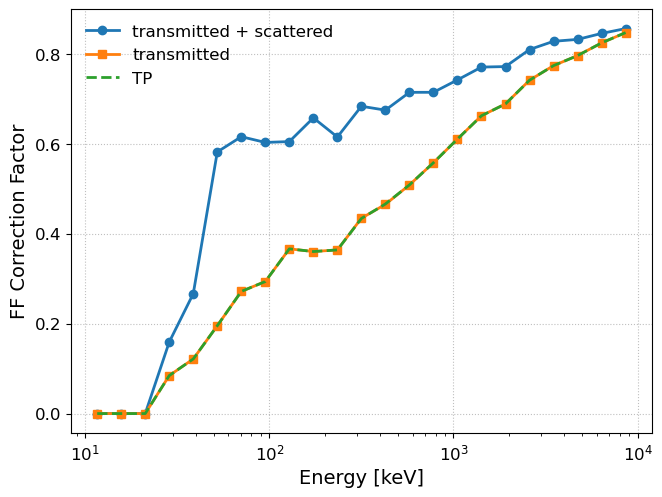

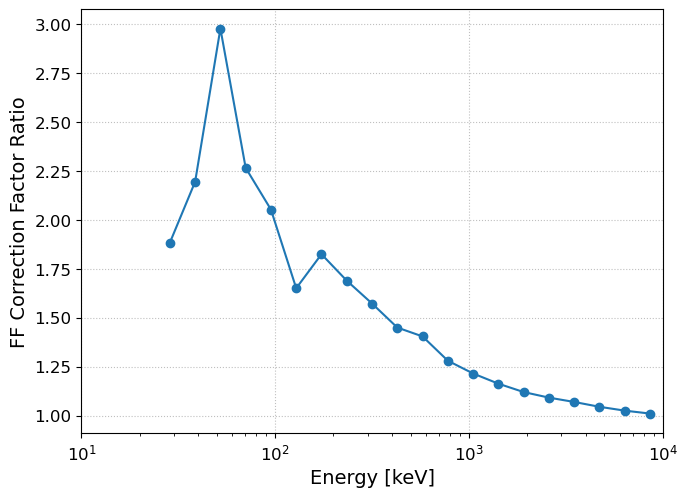

In [5]:
model_flux=instance.PL_interp(2)
instance.ff_correction(model_flux,"new_sims")